In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

from sklearn import metrics
from plotly import graph_objs as go
import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


<div class="alert alert-info" markdown="1">
    <h1>Data per leeftijd</h1>
    <p></p>
</div>

In [2]:
dataPA = pd.read_csv('data_per_leeftijd.csv')
#Kolommen die niet gebruikt worden verwijderen:
dataPA.drop(['Date_adj',
            ], axis=1, inplace=True)

#dataPD = dataPD.rename({'Aanwezig op IC verdacht of bewezen Corona' : 'IC_Opnames'}, axis=1)
dataPA.head()

,Age_group,Hospital_admission,IC_admission,Infection
0,0-19,16.0,1.0,71
1,20-29,28.0,6.0,504
2,30-39,90.0,10.0,551
3,40-49,190.0,44.0,718
4,50-59,547.0,147.0,1176


In [3]:
#Categorische variabelen omzetten naar binary variabelen
ageGroup = pd.get_dummies(dataPA["Age_group"])

#Bewerkte kolommen toevoegen aan dataframe
dataPA = pd.concat([dataPA,ageGroup], axis=1)

#kolom met categorische data verwijderen
dataPA.drop(['Age_group'], axis=1, inplace=True)

# IC_Admission verplaatsen naar laatste kolom
IC = dataPA.pop('IC_admission') 
dataPA['IC_admission']=IC
dataPA.head()

,Hospital_admission,Infection,0-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,IC_admission
0,16.0,71,1,0,0,0,0,0,0,0,0,1.0
1,28.0,504,0,1,0,0,0,0,0,0,0,6.0
2,90.0,551,0,0,1,0,0,0,0,0,0,10.0
3,190.0,718,0,0,0,1,0,0,0,0,0,44.0
4,547.0,1176,0,0,0,0,1,0,0,0,0,147.0


<h4>Onafhankelijke variabelen</h4>

In [4]:
# alle x variabelen selecteren
X_PA = dataPA.iloc[:,0:11].values.astype(float)

print("\nIndependend variabelen")
dataPA.iloc[:,0:11]



Independend variabelen


,Hospital_admission,Infection,0-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
0,16.0,71,1,0,0,0,0,0,0,0,0
1,28.0,504,0,1,0,0,0,0,0,0,0
2,90.0,551,0,0,1,0,0,0,0,0,0
3,190.0,718,0,0,0,1,0,0,0,0,0
4,547.0,1176,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
760,131.0,1451,0,0,0,0,1,0,0,0,0
761,251.0,1132,0,0,0,0,0,1,0,0,0
762,330.0,816,0,0,0,0,0,0,1,0,0
763,306.0,405,0,0,0,0,0,0,0,1,0


<h4>Afhankelijke variabele</h4>

In [5]:
# y variabele : IC_admission
y_PA = dataPA.iloc[:,11:12].values.astype(float)

print("\nDependent variabel")
dataPA.iloc[:,11:12]



Dependent variabel


,IC_admission
0,1.0
1,6.0
2,10.0
3,44.0
4,147.0
...,...
760,42.0
761,69.0
762,55.0
763,3.0


<h3>Training</h3>
<p>Data per leeftijd | Model 1 </p>

In [6]:
X_train_PA, X_test_PA, y_train_PA, y_test_PA = train_test_split(X_PA, y_PA, test_size=0.25, random_state=51)

#training en testset scaling 
sc_X_train_PA = StandardScaler()
sc_y_train_PA = StandardScaler()
sc_X_test_PA = StandardScaler()
sc_y_test_PA = StandardScaler()


X_train_PA = sc_X_train_PA.fit_transform(X_train_PA)
y_train_PA = sc_y_train_PA.fit_transform(y_train_PA)
X_test_PA = sc_X_test_PA.fit_transform(X_test_PA)
y_test_PA = sc_y_test_PA.fit_transform(y_test_PA)

In [7]:
#model 1 data per leeftijd trainen
model1_PA = SVR(kernel = 'rbf')
#model = SVR(kernel = 'rbf')
model1_PA.fit(X_train_PA,y_train_PA.ravel())

#- R2 is berekend als default score
print("R2 Score:",model1_PA.score(X_test_PA, y_test_PA))

#model1_PA.score(X_train, y_train)


R2 Score: 0.8361037627007215


<h2>Optimize parameters with Cross Validation </h2>
<p>Data per leeftijd | Model 2 </p>
<br/>

In [8]:
param_grid = [
{   'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)

optimal_params.fit(X_train_PA, y_train_PA.ravel())
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


<h3>Training </h3>
<p>Data per leeftijd | Model 2 </p>

In [9]:
#train model met gevonden paramaters
model2_PA = SVR(**optimal_params.best_params_)

model2_PA.fit(X_train_PA,y_train_PA.ravel())

model2_PA.score(X_test_PA, y_test_PA)

0.9594865169888798

<h3>Predictions </h3>
<p>Data per leeftijd | Model 2 </p>

In [10]:
y_pred_PA_model2 = model2_PA.predict(X_test_PA)


In [11]:
inv_y_pred_PA_Model2 = sc_y_train_PA.inverse_transform(y_pred_PA_model2.reshape(-1, 1) )
inv_y_test_PA = sc_y_test_PA.inverse_transform(y_test_PA)

In [12]:
mse = mean_squared_error(inv_y_test_PA, inv_y_pred_PA_Model2)
rmse = np.sqrt(mse)
r2 = r2_score(inv_y_test_PA, inv_y_pred_PA_Model2)

print("Mean squared error: ", mse)
print("Root-mean-square deviation:  ", rmse)
print("R2:  ", r2)



Mean squared error:  50.91197495290901
Root-mean-square deviation:   7.135262780928885
R2:   0.9560938963330041


Text(0.5, 1.0, 'Echte vs voorspelde waarde  | Model 1')

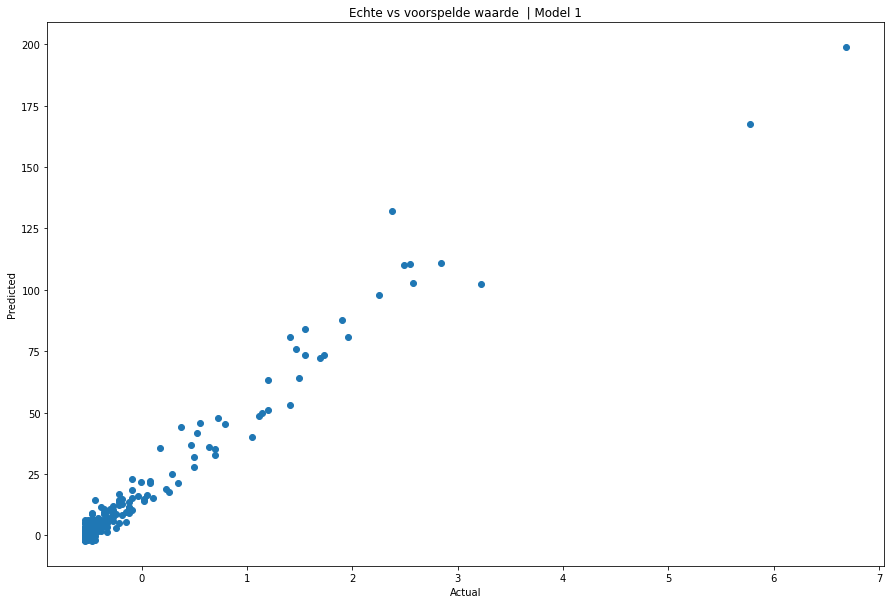

In [13]:
plt.figure(figsize=(15,10))
plt.scatter(y_test_PA,inv_y_pred_PA_Model2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Echte vs voorspelde waarde  | Model 1")

<div class="alert alert-info" markdown="1">
    <h1>Data per dag</h1>
    <p></p>
</div>

In [14]:
dataPD = pd.read_csv('data_per_dag.csv')

dataPD.head()

,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Date_adj,Infection
0,246,1310,24,0,24,200,4,204,2021-11-01,10966
1,231,1175,23,0,23,130,3,133,2021-10-31,8817
2,222,1119,13,0,13,139,2,141,2021-10-30,8487
3,234,1101,27,0,27,157,2,159,2021-10-29,8424
4,220,1026,23,0,23,136,6,142,2021-10-28,7930


In [15]:
#Kolommen die niet gebruikt worden verwijderen:
dataPD.drop(['Opname IC verdacht',
             'Opname IC Corona',
             'Opname IC totaal',
             'Opname verpleegafdeling Corona', 
             'Opname verpleegafdeling verdacht',
             'Aanwezig op verpleegafdeling verdacht of bewezen Corona',
             'Date_adj',
            ], axis=1, inplace=True)

dataPD = dataPD.rename({'Aanwezig op IC verdacht of bewezen Corona' : 'IC_Opnames'}, axis=1)
dataPD.head()

,IC_Opnames,Opname verpleegafdeling totaal,Infection
0,246,204,10966
1,231,133,8817
2,222,141,8487
3,234,159,8424
4,220,142,7930


<h4>Onafhankelijke variabele</h4>

In [16]:
X_PD = dataPD.iloc[:,1:3].values.astype(float)
print("n\Independend variabelen")
dataPD.iloc[:,1:3]

n\Independend variabelen


,Opname verpleegafdeling totaal,Infection
0,204,10966
1,133,8817
2,141,8487
3,159,8424
4,142,7930
...,...,...
590,217,874
591,266,1000
592,285,825
593,191,865


<h4>Afhankelijke variabele</h4>

In [17]:
y_PD = dataPD.iloc[:,0:1].values.astype(float)
print("n\Dependend variabelen")
dataPD.iloc[:,0:1]

n\Dependend variabelen


,IC_Opnames
0,246
1,231
2,222
3,234
4,220
...,...
590,437
591,367
592,296
593,236


<h3>Training</h3>
<p>Data per dag | Model 1 </p>
<br>

In [18]:
X_train_PD, X_test_PD, y_train_PD, y_test_PD = train_test_split(X_PD, y_PD, test_size=0.25, random_state=51)

#training en testset scaling 
sc_X_train_PD = StandardScaler()
sc_y_train_PD = StandardScaler()
sc_X_test_PD = StandardScaler()
sc_y_test_PD = StandardScaler()


X_train_PD = sc_X_train_PD.fit_transform(X_train_PD)
y_train_PD = sc_y_train_PD.fit_transform(y_train_PD)
X_test_PD = sc_X_test_PD.fit_transform(X_test_PD)
y_test_PD = sc_y_test_PD.fit_transform(y_test_PD)

In [19]:
#model 1 data per dag trainen
model1_PD = SVR(kernel = 'rbf')
model1_PD.fit(X_train_PD,y_train_PD.ravel())

print("R2 Score op basis van test data:")
#- R2 is berekend als default score
model1_PD.score(X_test_PD, y_test_PD)

R2 Score op basis van test data:


0.7146722414273741

<h2>Optimize parameters with Cross Validation </h2>
<p>Data per dag | Model 2 </p>
<br/>

In [20]:
param_grid = [
{   'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)

optimal_params.fit(X_train_PD, y_train_PD.ravel())
print(optimal_params.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


<h3>Training </h3>
<p>Data per dag | Model 2 </p>

In [21]:
model2_PD = SVR(**optimal_params.best_params_)

model2_PD.fit(X_train_PD,y_train_PD.ravel())
model2_PD.score(X_test_PD, y_test_PD)

0.7200213756825371

<h3>Predictions </h3>
<p>Data per dag | Model 2 </p>

In [22]:
y_pred_PD_model2 = model2_PD.predict(X_test_PD)

In [23]:
inv_y_pred_PD_Model2 = sc_y_test_PD.inverse_transform(y_pred_PD_model2.reshape(-1, 1) )
inv_y_test_PD = sc_y_test_PD.inverse_transform(y_test_PD)

In [24]:
mse = mean_squared_error(inv_y_test_PD, inv_y_pred_PD_Model2)
rmse = np.sqrt(mse)
r2 = r2_score(inv_y_test_PD, inv_y_pred_PD_Model2)

print("Mean squared error: ", mse)
print("Root-mean-square deviation:  ", rmse)
print("R2:  ", r2)

Mean squared error:  20128.249894035544
Root-mean-square deviation:   141.8740635001181
R2:   0.7200213756825371


Text(0.5, 1.0, 'Echte vs voorspelde waarde  | Model 2')

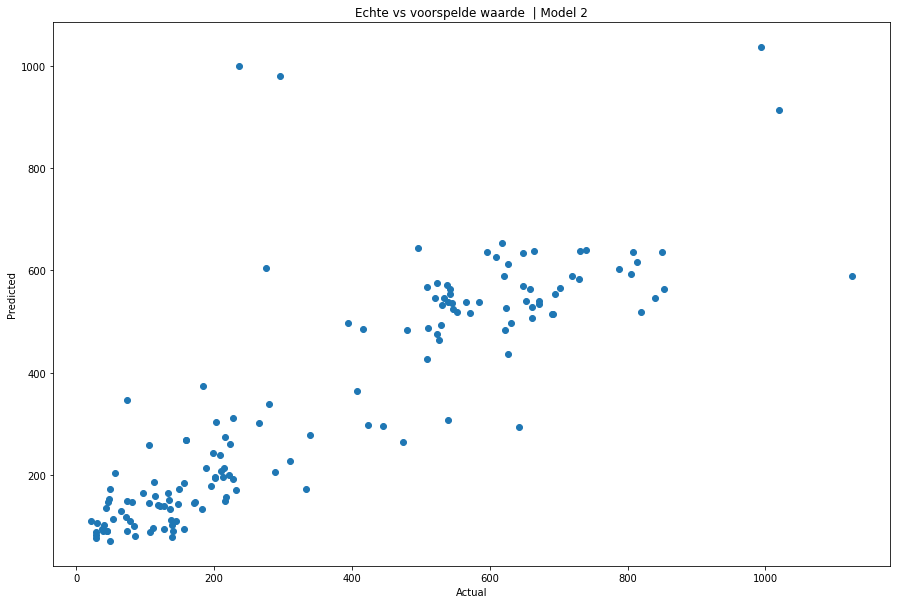

In [25]:
plt.figure(figsize=(15,10))
plt.scatter(inv_y_test_PD,inv_y_pred_PD_Model2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Echte vs voorspelde waarde  | Model 2")